# IoT Data Science Project

This notebook demonstrates our process of training a model using TensorFlow and converting it for use with TensorFlow Lite for Microcontrollers. 


## Configure Defaults

In [ ]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
try:
  os.mkdir(MODELS_DIR)
except FileExistsError:
  pass
MODEL_TF = MODELS_DIR + 'model.pb'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [ ]:
%pip install tensorflow pandas numpy plotly
!apt install -y xxd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xxd is already the newest version (2:8.1.2269-1ubuntu5.14).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Set Seed for Repeatable Results

In [ ]:
# Set a "seed" value, so we get the same random numbers each time we run this
# notebook for reproducible results.
# Numpy is a math library
import numpy as np
np.random.seed(1) # numpy seed
# TensorFlow is an open source machine learning library
import tensorflow as tf
tf.random.set_seed(1) # tensorflow global random seed

Import Dependencies

In [ ]:
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Plotly for graphing library
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Math is Python's math library
import math

## Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

assert("input.npy" in uploaded.keys())
assert("output.npy" in uploaded.keys())

Saving output.npy to output.npy
Saving input.npy to input.npy


In [ ]:
x_values = np.load("input.npy")
y_values = np.load("output.npy")

print(x_values.shape)
print(y_values.shape)
assert(x_values.shape[0] == y_values.shape[0])

print(x_values.shape,x_values[0])

SAMPLES = x_values.shape[0]
INPUT_SIZE = x_values.shape[1]
OUTPUT_SIZE = y_values.shape[1]

(8992, 20)
(8992, 2)
(8992, 20) [0.99 0.98 0.99 0.99 0.99 0.99 0.98 0.98 0.99 0.99 0.98 0.98 0.99 0.99
 0.99 0.99 0.99 0.99 0.99 0.99]


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

x_values = scaler.fit_transform(x_values)

We print the attributes of the scaler to easily paste them into the arduino code.

In [ ]:
print(*scaler.mean_, sep = ', ')
print(*scaler.scale_, sep = ', ')

1.002244217081706, 0.9969739768681863, 0.9780427046261917, 0.9774699733094625, 0.9885242437720999, 0.9912844750888308, 0.9855393683272579, 0.9825700622774357, 0.9850900800710304, 0.98709630782904, 0.9885487099642675, 0.9860542704624866, 0.9812700177934556, 0.9842415480425621, 0.9943527580069715, 0.9891570284696034, 0.9749644128112522, 0.9777680160141146, 1.0058463078290605, 1.0034842081849311
0.057016487613638034, 0.043192446111424754, 0.04688370512457536, 0.04284471606258267, 0.039743557294276026, 0.03810319196110418, 0.0391970454251776, 0.03818838200425476, 0.036293961922855646, 0.03904424872185462, 0.04310507194035918, 0.03947357881955382, 0.03882232144002737, 0.04378275001672496, 0.049458627264599826, 0.04295937918789064, 0.042593299062306945, 0.05143179509233413, 0.0602858327289839, 0.055622827997059886


### 3. Split the Data
We will be using our data to train our model.

The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20% 


In [ ]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

shuffle = np.arange(x_values.shape[0])
print(shuffle)
np.random.shuffle(shuffle)
print(shuffle)
x_values = x_values[shuffle]
y_values = y_values[shuffle]
print(x_values.shape)
print(y_values.shape)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.shape[0] + x_validate.shape[0] + x_test.shape[0]) ==  SAMPLES

print("Class balance in train:", np.sum(y_train, axis=0))
print("Class balance in test:", np.sum(y_test, axis=0))
print("Class balance in validate:", np.sum(y_validate, axis=0))

[   0    1    2 ... 8989 8990 8991]
[7885 8231 7798 ...  905 5192  235]
(8992, 20)
(8992, 2)
Class balance in train: [2678. 2717.]
Class balance in test: [932. 866.]
Class balance in validate: [886. 913.]


## Training

### 1. Design the Model
We're going to build a simple neural network model that will take 20 input values (a time series of values) and use it to classify a tap or not a tap. This type of problem is called a classification. It will use _layers_ of _neurons_ to attempt to learn any patterns underlying the training data, so it can make classifications.

In [ ]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 8 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(INPUT_SIZE,)))
model_1.add(keras.layers.Dense(OUTPUT_SIZE, activation='softmax'))

# Compile the model using a standard optimizer and loss function for binary classification
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 8)                 168       
                                                                 
 dense_17 (Dense)            (None, 2)                 18        
                                                                 
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________


### 2. Train the Model
Once we've defined the model, we can use our data to _train_ it. 


In [ ]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=150, batch_size=64,
                    validation_data=(x_validate, y_validate))

Epoch 1/150
85/85 [==============================] - 1s 5ms/step - loss: 0.6574 - mae: 0.4500 - val_loss: 0.5835 - val_mae: 0.3837
Epoch 2/150
85/85 [==============================] - 1s 6ms/step - loss: 0.5375 - mae: 0.3431 - val_loss: 0.4858 - val_mae: 0.3008
Epoch 3/150
85/85 [==============================] - 1s 11ms/step - loss: 0.4495 - mae: 0.2704 - val_loss: 0.4070 - val_mae: 0.2362
Epoch 4/150
85/85 [==============================] - 1s 6ms/step - loss: 0.3741 - mae: 0.2070 - val_loss: 0.3364 - val_mae: 0.1759
Epoch 5/150
85/85 [==============================] - 1s 7ms/step - loss: 0.3044 - mae: 0.1471 - val_loss: 0.2711 - val_mae: 0.1210
Epoch 6/150
85/85 [==============================] - 1s 7ms/step - loss: 0.2431 - mae: 0.0988 - val_loss: 0.2170 - val_mae: 0.0821
Epoch 7/150
85/85 [==============================] - 0s 6ms/step - loss: 0.1943 - mae: 0.0669 - val_loss: 0.1753 - val_mae: 0.0580
Epoch 8/150
85/85 [==============================] - 0s 5ms/step - loss: 0.1580 - 

### 3. Plot Metrics

**1. Mean Squared Error**


In [ ]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = list(range(1, len(loss) + 1))


fig = go.Figure()
fig.add_trace(
    go.Scatter(x = epochs, y = loss, name = "Training loss", mode = "markers")
)
fig.add_trace(
    go.Scatter(x = epochs, y = val_loss, name = "Validation loss", mode = "markers")
)
fig.update_layout(
    xaxis = dict(title = "Epochs"),
    yaxis = dict(title = "Loss"),
    title = "Training and Validation loss"
)
fig.show()


As we can see, the amount of loss rapidly decreases over the first 20 epochs, before flattening out. This means that the model is improving and producing more accurate predictions!


In [ ]:
# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

fig = go.Figure()
fig.add_trace(
    go.Scatter(x = epochs, y= mae, name = "Training MAE", mode = "markers")
)
fig.add_trace(
    go.Scatter(x = epochs, y= val_mae, name = "Validation MAE", mode = "markers")
)
fig.update_layout(
    xaxis = dict(title = "Epochs"),
    yaxis = dict(title = "MAE"),
    title = "Training and validation mean absolute error"
)
fig.show()

57/57 [==============================] - 0s 1ms/step


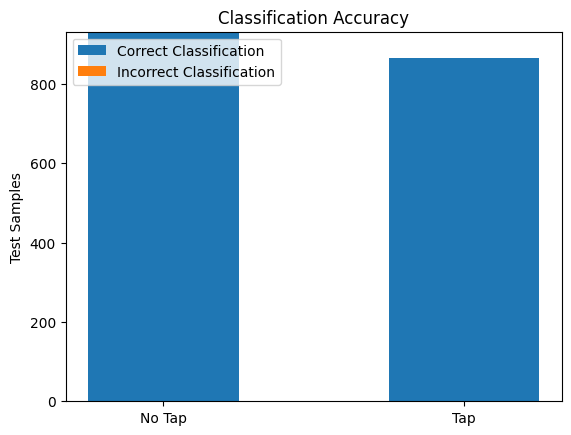

1.0


In [ ]:
# Use the model to make predictions from our validation data
predictions = model_1.predict(x_test)

correct = [0, 0]
wrong = [0, 0]

for i in range(predictions.shape[0]):
    p = np.argmax(predictions[i])
    a = np.argmax(y_test[i])

    if p == a:
        correct[a] += 1
    else:
        wrong[a] += 1

import matplotlib.pyplot as plt
%matplotlib inline


species = ['No Tap', 'Tap']
weight_counts = {
    "Right": correct,
    "wrong": wrong,
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count
plt.title("Classification Accuracy")
plt.ylabel("Test Samples")
plt.legend(["Correct Classification", "Incorrect Classification"])
plt.show()

total = sum(weight_counts["Right"]) + sum(weight_counts["wrong"])

print(sum(weight_counts["Right"])/total)


## Generate a TensorFlow Lite Model

### 1. Generate Models with or without Quantization
We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

In the following cell, we'll convert the model twice: once with quantization, once without.

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
model_no_quant_tflite = converter.convert()

# # Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(x_train.shape[0]):
    yield([x_train[i].astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce full-int8 quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



2264

### 2. Compare Model Sizes

In [ ]:
import sys, os
def format_size(variable):
    size_in_bytes = sys.getsizeof(variable)
    units = ["B", "KB", "MB", "GB", "TB"]
    unit_index = 0
    while size_in_bytes >= 1024 and unit_index < len(units) - 1:
        size_in_bytes /= 1024.0
        unit_index += 1
    return "{:.2f} {}".format(size_in_bytes, units[unit_index])

print("Model is {}".format(format_size(model_no_quant_tflite)))
print("Quantized Model is {}".format(format_size(model_tflite)))

Model is 2.46 KB
Quantized Model is 2.24 KB


Our quantized model is only 0.22 kilobytes smaller than the original version, which only a tiny reduction in size! Because the difference is so small, we will use the unquantized version in our arduino.

### 3. Test the Models

To prove these models are still accurate after conversion and quantization, we'll use both of them to make predictions and compare these against our test results:

## Generate a TensorFlow Lite for Microcontrollers Model
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file
!xxd -i {MODEL_NO_QUANT_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_NO_QUANT_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done


## Deploy to a Microcontroller

Follow the instructions in the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) README.md for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview) to deploy this model on a specific microcontroller.

**Reference Model:** If you have not modified this notebook, you can follow the instructions as is, to deploy the model. Refer to the [`hello_world/train/models`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/models) directory to access the models generated in this notebook.

**New Model:** If you have generated a new model, then update the values assigned to the variables defined in [`hello_world/model.cc`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/model.cc) with values displayed after running the following cell.

**Errors:** Type should match; otherwise, there will be an error. In your model.ccp and model.h files, make sure that the type matches. If it's declared as "const unsigned char g_model[]" make sure that it is the same in both places. 

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x98, 0x00, 0x00, 0x00, 0xf0, 0x00, 0x00, 0x00, 0xc4, 0x04, 0x00, 0x00,
  0xd4, 0x04, 0x00, 0x00, 0x54, 0x09, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff, 0x07, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x31, 0x37, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x